In [1]:
import cv2
import json
import treepoem
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

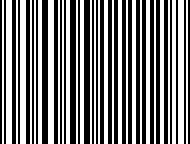

In [2]:
barimg = treepoem.generate_barcode('ean13', '100000011111')
barimg

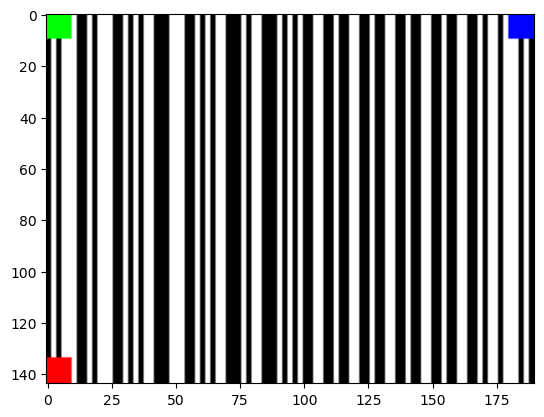

In [3]:
bar = np.array(barimg).copy()
bar[-10:, :10] = [255, 0, 0]
bar[:10, :10] = [0, 255, 0]
bar[:10, -10:] = [0, 0, 255]

plt.imshow(bar)

In [82]:
def generate_perspective_distort(corners, alpha=0.1, beta=0.01):
    M = np.zeros((3,3))
    M[:-1,:-1] = np.random.randn(2, 2)*alpha + np.eye(2)*(1.-alpha)
    M[-1, :-1] = beta*np.abs(np.random.randn(1,2))
    M[:-1,-1] *= 0
    M[-1,-1] = 1
    coords = (M@corners)[:-1]
    M[:-1,-1] = -np.min(coords, axis=-1)
    return M

def aligned_perspective(img):
    height, width, _ = img.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
    M = generate_perspective_distort(corners)
    coords = M@corners
    coords = coords[:-1]/coords[-1]
    
    new_sz = np.ceil(np.max(coords, axis=-1)).astype(np.int32)
    
    img = cv2.warpPerspective(bar, M, new_sz)
    return img, coords

array([[ 6.03467098,  0.        , 75.12466214, 49.16142689],
       [45.21393661,  0.        ,  1.73722471, 30.34407946]])

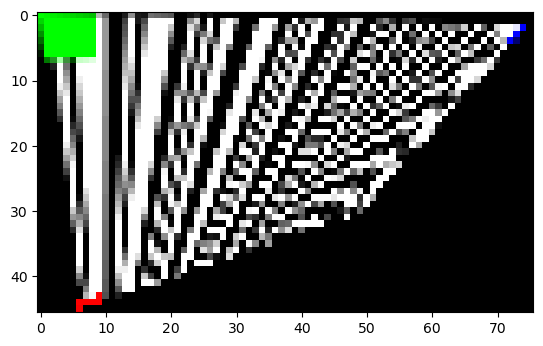

In [106]:
xps = [0, 0, 1, 1]
yps = [1, 0, 0, 1]

height, width, _ = bar.shape
corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
M = generate_perspective_distort(corners)
coords = M@corners
coords = coords[:-1]/coords[-1]

new_sz = np.ceil(np.max(coords, axis=-1)).astype(np.int32)

img = cv2.warpPerspective(bar, M, new_sz)
plt.imshow(img)
coords

In [ ]:
# M = [
#     [1, 0, 0.],
#     [0, 1, 0.]
# ]
# M = np.array(M)
M = np.random.randn(2, 3)
M[:, -1] = np.abs(M[:, -1]*100)
img, coords = aligned_affine(bar, M.copy(), fix_position=True)
plt.imshow(img)

In [ ]:
coords

In [ ]:
np.min([coords, coords, coords], axis=(0, 2))

In [ ]:
def load_json(fname, *args, **kwargs):
    with open(fname) as f:
        return json.load(f, *args, **kwargs)

def save_json(jd, fname, *args, indent=4, **kwargs):
    with open(fname, 'w') as f:
        json.dump(jd, f, *args, indent=indent, **kwargs)

In [ ]:
load_json('../dataset/multiple_barcodes_example.json')

In [ ]:
len('100000011111')

In [ ]:
treepoem.barcode_types['code93']

In [ ]:
np.random.choice(list(treepoem.barcode_types), 7)